<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Week-1-Analysis" data-toc-modified-id="Week-1-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Week 1 Analysis</a></span><ul class="toc-item"><li><span><a href="#Step-5:-Flushing-Cell-with-N2-for-calibration" data-toc-modified-id="Step-5:-Flushing-Cell-with-N2-for-calibration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Step 5: Flushing Cell with N2 for calibration</a></span></li></ul></li></ul></div>

In [278]:
import re
import sys
import os
#sys.path.insert(0, '../..')
#os.chdir('../../../')

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from scipy.fftpack import fft, fftshift

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]

# Helper Functions

In [279]:
POWERS2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

class Interferogram:
    
    def __init__(self, DIR, filename):
        self.dir = DIR
        self.filename = filename
        
        with open(DIR+filename) as f:
            data = f.read().splitlines() 
        
        # Read in params at the top of the file
        self.datestamp = data[0].replace("#","").strip()
        result = re.search(r'\d+', data[1])
        self.res = int(result.group())
        result = re.search(r'\d+', data[2])
        self.vel = int(result.group())
        result = re.search(r'\d+', data[3])
        self.LP = int(result.group())
        result = re.search(r'\d+', data[4])
        self.HP = int(result.group())
        result = re.search(r'\d+', data[5])
        self.gain = int(result.group())
        
        # Read in the raw spectrum data
        raw = list(filter(None, data[6:]))
        scan_idx = [i for i in range(0, len(raw)) if "#" in raw[i]]
        scan_idx.append(len(raw))
        self.raw_data = np.array(
            [np.array(raw[scan_idx[i]+1:scan_idx[i+1]], dtype=np.float) for i in range(0, len(scan_idx)-1)]
        )

        # Normalize by subtracting the mean and doing zero fill
        mean = np.mean(np.array([x for x in raw if "#" not in x], dtype=np.float))
        self.data = self.mertz(mean)
        
    def mertz(self, mean):
        new_data = []

        for line in self.raw_data:
            power = 0
            for i in range(0, len(POWERS2)):
                if POWERS2[i] >= len(line):
                    power = i
                    break
            
            # Add the zero fill and normalize
            new_line = np.concatenate((line, np.zeros(POWERS2[i]-len(line)))) - mean
            
            # find burtst location
            burst = np.argmax(new_line)
            
            # Add the triangular phase correction
            new_line = np.multiply(new_line, Interferogram.triangular_signal(burst, len(new_line)))
            
            # Slicing to rotate about ZPD
            new_line = np.concatenate((new_line[burst:], new_line[:burst]))
            
            new_data.append(new_line)
        
        return np.array(new_data)
    
    @staticmethod
    def triangular_signal(center, total_len):
        window = signal.triang(2*center-1)
        return np.concatenate((window, np.zeros(total_len-len(window))))
    
    def dictify(self):
        return {
            "filename": self.filename,
            "datestamp": self.datestamp,
            "resolution": self.res,
            "velocity": self.vel,
            "LP": self.LP,
            "HP": self.HP,
            "gain": self.gain
        }

# Week 1 Analysis

In [280]:
DIR = "week1/"

## Step 5: Flushing Cell with N2 for calibration

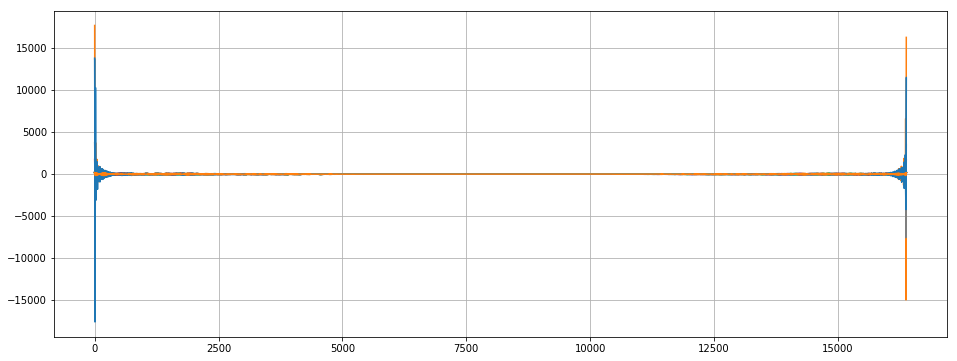

In [281]:
filename = "week1_step5_n2_flush.txt"
curr = Interferogram(DIR, filename)

plt.figure()
for data in curr.data:
    plt.plot(data)
plt.grid(True)

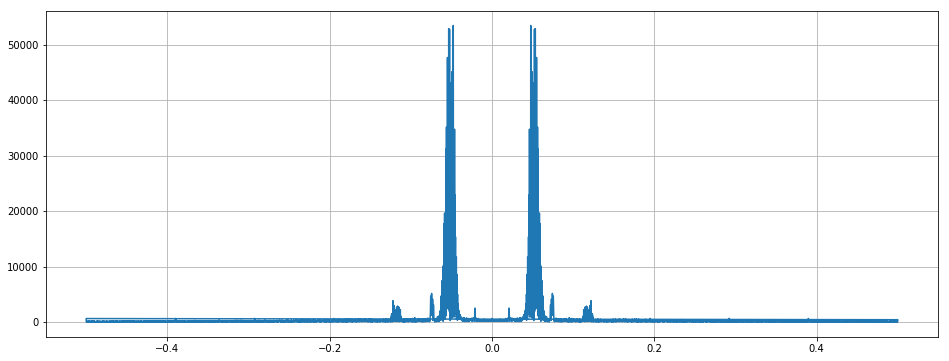

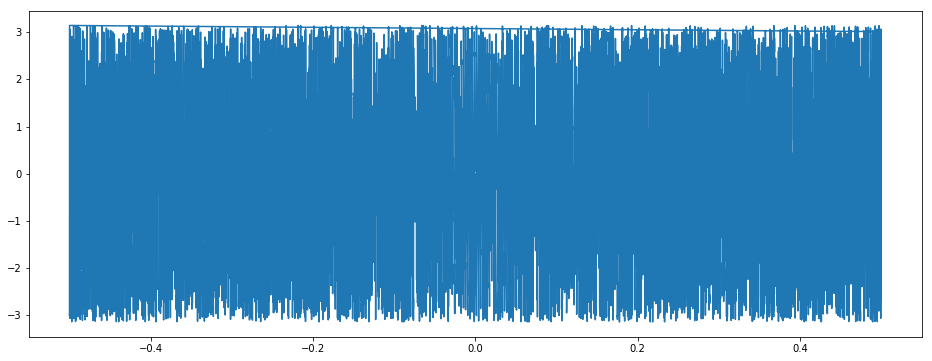

In [282]:
Y    = np.fft.fft(curr.data[0])
freq = np.fft.fftfreq(len(curr.data[0]))

plt.figure()
plt.plot( freq, np.abs(Y) )
plt.grid(True)
plt.figure()
plt.plot(freq, np.angle(Y) )
plt.show()